In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch_lr_finder import LRFinder
import data,utils,model,engine
from torchsummary import summary

In [4]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = {
    'batch_size': 512,
    'shuffle': True,
    'num_workers': 0,
    'pin_memory': True,
}  

In [21]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? False


In [6]:
transform = data.transformed_data()
dataset = data.get_data(transform)
loader = data.get_dataloader(dataset, dataloader_args)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

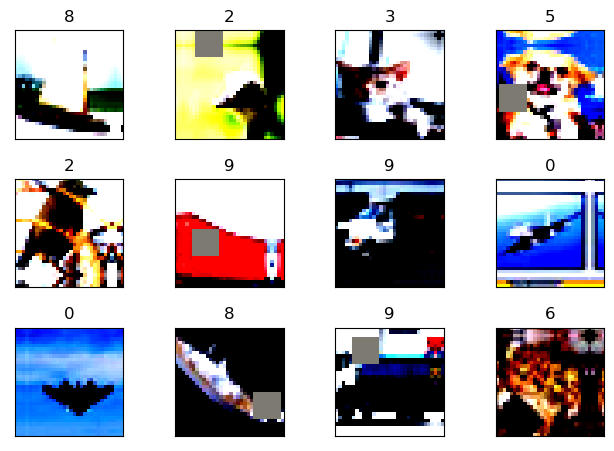

In [9]:
utils.plot_batch_samples(loader['train'])

In [27]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
criterion = nn.CrossEntropyLoss()
model = Res_Net().to(device)
summary(model, input_size=(3, 32, 32))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        SkipBlock-14          [-1, 

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.38E-02


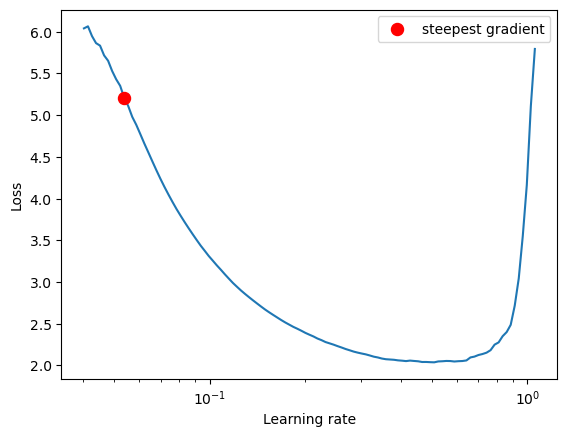

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.05378694867345563)

In [29]:
from torch_lr_finder import LRFinder

model = Res_Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1E-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cpu")
lr_finder.range_test(loader['train'], end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph

In [30]:
import engine

In [ ]:
EPOCHS = {
    'num_epochs': 24,
}
params_scheduler = {
    'max_lr': 5.38E-02, # From lr_finder
    'epochs': EPOCHS ['num_epochs'],
    'steps_per_epoch': len(loader['train']), # 1 batch per step
    'pct_start': 0.2, # 20 % warm-up phase
    'anneal_strategy': 'linear', # Linear cool-down phase
    'three_phase': False, # No annihilation phase
    'div_factor': 100, # Initial LR: start from 1 % of max_lr
}

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, **params_scheduler)

results = engine.train(
    device,
    loader['train'],
    loader['test'],
    model,
    criterion,
    optimizer,
    scheduler,
    EPOCHS['num_epochs'],
)

  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.03941, Accuracy = 14.56%, Epoch = 1
Test : Loss = 0.00846, Accuracy = 15.89%



  0%|          | 0/98 [00:00<?, ?it/s]

In [ ]:
utils.plot_learning_curves(results,EPOCHS ['num_epochs'])

In [ ]:
incorrects = utils.get_incorrect_predictions(
    device,
    data.get_dataloader(dataset, dataloader_args)['test'],
    model,
    criterion
)

In [ ]:
utils.plot_incorrect_predictions(incorrects, data.CLASSES)